# 8.1.1统计工具

处理序列数据，需要统计工具和新的深度神经网络架构。
为了简单起见，我们以下图的富时100指数为例。

![ftse100](imgs/ftse100.png)

其中，用$x_t$表示价格，
即在时间步t时，观察到的价格$x_t$。


为了实现预测，
交易员可以使用回归模型，例如线性回归。

**仅有一个问题**

输入数据的数量，
输入数据$x_{t-1},...,x_1$本身因t而异。

也就是说，输入数据的数量这个数字会随着我们遇到数据的增加而增加，

因此需要一个近似方法来让计算变得容易。

简单来说，它归结为以下两种策略：

1. 假设在现实情况下相当长的序列$x_{t-1},...,x_1$可能是不必要的，
    因此，我们只需要满足某个长度为$\tau$的时间跨度，
   即使用观测序列$x_{t-1},...,x_{t-\tau}$。
   这样获得的直接好处是参数的总量是不变的，至少在$t>\tau$时如此。
   这种模型我们称之为*自回归模型（autoregressive model）*，因为它们是对自己执行回归
2. 第二中策略，是保留以下对过去观测的总结$h_t$，并且同时封信预测$\hat{x}_t$和总结$h_t$。由于$h_t$从来没有被观测到，这类模型被称为*隐变量自回归模型（latent autoregressive model）*


## 训练
首先我们生成一些数据：使用正弦函数和一些噪声来生成序列数据，时间步为
1，2，3，...，100

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

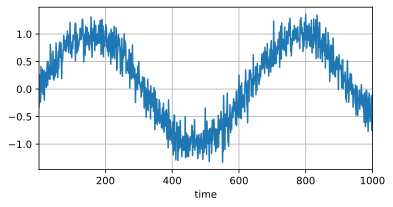

In [38]:
T = 1000 # 共产生1000个点
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0,0.2,(T,))
d2l.plot(time, [x], 'time', xlim=[1, 1000],figsize=(6, 3))

接下来，我们把这个序列转化为“特征-标签”（feature-label）对。

基于嵌入维度$\tau$，

我们把数据映射为数据对$y_t = x_t$和$x_t = [x_{t-\tau},...,x_{t-1}]$

（注意$x_t = [x_{t-\tau},...,x_{t-1}]$包含$t-1-t+\tau+1=\tau$个样本）

eg. tau = 4, t = 8
[8-4, 7] = [4,7] = [4,5,6,7]

你可能已经注意到，这比我们提供的数据样本少了$\tau$个。

这是因为我们没有足够的历史数据取来描述前$\tau$个样本。

一个简单的办法就是：

如果拥有足够长的序列就丢弃这几项；
或者采用0填充序列。

这里我们仅使用前600个“特征-标签”对进行训练。

In [48]:
tau = 4 # 嵌入维度，长度为tau的时间跨度

# 996个数据，每个数据包含4个特征（4次观测）
features = torch.zeros((T-tau, tau)) # (996,4)

# 对特征变量的4个属性，使用x的1000个数进行赋值
# 赋值想象册成填数字，竖着填，每一列shift一个数字
# print(x.shape) # x是生成的1000个数据值（标量）

for i in range(tau):
    # 特征的所有行，逐列 使用x赋值
    # print(f':{i} <- {i}:{T-tau+i}')
    # print(features[:, i].shape)
    features[:, i] = x[i:T-tau+i]
# print(features.shape) # 996 * 4
# 要给这996个数字制作标签，从第tau=4个开始，都是标签，总共996个
labels = x[tau:].reshape((-1,1))
# print(labels.shape) # 996 * 1

In [49]:
t = torch.arange(1,100) # 自变量
table = torch.zeros(size=(25,4))
for i in range(4):
    print(f'{i} <- {i}:{25+i}')
    table[:,i] = t[i:25+i]
print(table)

0 <- 0:25
1 <- 1:26
2 <- 2:27
3 <- 3:28
tensor([[ 1.,  2.,  3.,  4.],
        [ 2.,  3.,  4.,  5.],
        [ 3.,  4.,  5.,  6.],
        [ 4.,  5.,  6.,  7.],
        [ 5.,  6.,  7.,  8.],
        [ 6.,  7.,  8.,  9.],
        [ 7.,  8.,  9., 10.],
        [ 8.,  9., 10., 11.],
        [ 9., 10., 11., 12.],
        [10., 11., 12., 13.],
        [11., 12., 13., 14.],
        [12., 13., 14., 15.],
        [13., 14., 15., 16.],
        [14., 15., 16., 17.],
        [15., 16., 17., 18.],
        [16., 17., 18., 19.],
        [17., 18., 19., 20.],
        [18., 19., 20., 21.],
        [19., 20., 21., 22.],
        [20., 21., 22., 23.],
        [21., 22., 23., 24.],
        [22., 23., 24., 25.],
        [23., 24., 25., 26.],
        [24., 25., 26., 27.],
        [25., 26., 27., 28.]])


In [50]:
batch_size = 16
n_train = 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array(
    (features[:n_train], labels[:n_train]),
    batch_size=batch_size,
    is_train=True
)

In [51]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 简单的多层感知机
def get_net():
    net = nn.Sequential(
        nn.Linear(4,10),
        nn.ReLU(),
        nn.Linear(10,1)
    )
    net.apply(init_weights)
    return net

# 使用均方误差，并且不带系数 1/2
loss = nn.MSELoss(reduction='none')

In [56]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.068325
epoch 2, loss: 0.059966
epoch 3, loss: 0.054400
epoch 4, loss: 0.051424
epoch 5, loss: 0.052223


## 预测
由于训练损失很小，因此我们期望模型能够有很好的工作效果。

首先检查模型预测下一个时间步的能力（也就是单步预测）
one-step-ahead prediction

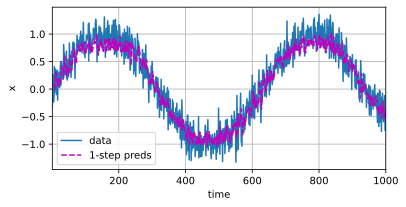

In [62]:
onestep_preds = net(features) # 使用原始数据进行预测
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()],
         'time','x',legend=['data','1-step preds'],
         xlim=[1,1000],figsize=(6,3))

正如我们所料，单步预测效果不错。

即使这些预测的时间步超过了600+4（n_train + tau），
结果看起来仍旧是可信的。

然而有一个小问题：如果数据观察序列的时间步只到604，

我们需要一步一步地向前迈进：
$$
\begin{split}\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots\end{split}
$$

通常，对于直到$x_t$的观测序列，
其在时间步$t+k$处的预测$\hat{x}_{t+k}$，

我们称之为k步预测。
由于我们的观察已经到了$x_{604}$，它的k步预测是$\hat{x}_{604+k}$.

换句话说，我们必须使用我们自己的预测来进行多步预测

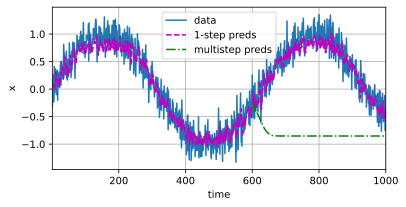

In [77]:
multistep_preds = torch.zeros(T)

# 多步预测
# 从前数604步开始，是原始的数据，后面的用0填充
multistep_preds[: n_train + tau] = x[: n_train + tau]

for i in range(n_train+tau, T):
    # 对剩下的604~1000原素，逐个做运算

    # 第i个元素，由net(i前4个元素决定)
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1))
    )

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

如上面的例子所示，绿线的预测显然并不理想。
经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。

这是由于，
错误的累积： 假设在步骤之后，我们积累了一些错误$\epsilon_1 = \bar\epsilon$

于是，步骤的输入被扰动了$\epsilon_1$，

结果积累的误差是依照次序的$\epsilon_2 = \bar\epsilon + c \epsilon_1$，

其中c为某个常数，后面的预测误差依此类推。 因此误差可能会相当快地偏离真实的观测结果。


通常，对于直到$x_t$的观测序列，
其在时间步$t+k$处的预测$\hat{x}_{t+k}$，

我们称之为k步预测。
由于我们的观察已经到了$x_{604}$，它的k步预测是$\hat{x}_{604+k}$.

换句话说，我们必须使用我们自己的预测来进行多步预测

基于k=1,4,16,64，通过对整个序列预测的计算， 让我们更仔细地看一下步预测的困难。

In [80]:
max_steps = 64
# 要进行k步预测，时间步长度依然为tau=4
# 在之前、features = torch.zeros((T-tau, tau)) # (996,4)
features = torch.zeros(size=(T-tau-max_steps+1, tau+max_steps))
# 列i(i<tau)是来自x的观测，其时间步从i到i+T-tau-max_steps+1
print(features.shape)
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

torch.Size([933, 68])


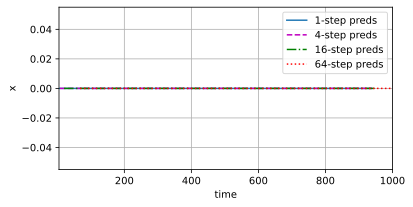

In [81]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

# 文本预处理

在本部分，我们将解析文本常见的预处理步骤，
这些步骤通常包括：

1. 将文本作为字符加载到内存
2. 将字符串拆分成词元（如单词和字符）
3. 建立词表，将拆分的词元映射到数字索引
4. 将文本转换成数字索引序列，方便模型操作

In [82]:
import collections
import re
from d2l import torch as d2l

## 读取数据集

首先从“时光机”中加载文本，这是一个相当小的语料库，只有30_000多个单词，
但实际上的文档可能包含数十亿的单词。

下面的函数把数据集读取到由多条文本行组成的列表中，

其中每条文本行都是一个字符串。

问了简单起见，忽略标点和字母大写。

In [84]:
#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# 文本总行数: {len(lines)}')


# 文本总行数: 3221


## 词元化（token）
下面的tokenize函数把文本lines作为输入，

列表中每一个元素是文本序列（一行文本）。

每个文本序列，

继续拆分成一个词元列表，

**词元（token）是文本的基本单位。**

最后，返回一个由词元列表组成的列表，
其中的每个词元都是一个字符串（string）。



In [90]:
def tokenize(lines, token='word'):
    """
    将文本拆分成单词或者字符词元
    :param lines: 列表
    :param token: word or char
    :return: list
    """
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        raise Exception('错误：未知词元类型：'+token)

In [91]:
tokens = tokenize(lines)
for i in token[:10]:
    print(i)

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']


## 词表（Vocab）

词元的类型是字符串，但是模型需要的是数字。

现在，我们构建一个字典，通常也叫做词表（vocabulary），

用来将字符串类型的词元映射到从0开始的数字索引中。

我们首先把训练集中所有文档合到一起，

**对它们的唯一词元做统计，**

**将得到的统计结果叫做语料（corpus）。**

然后根据每个唯一词元出现的频率，为其分配一个数字索引。

很少出现的词元通常被移除，这可以降低复杂性。
另外，语料库中不存在或已删除的任何词元都将映射到一个特定的未知词元“\<unk\>”。
我们可以选择增加一个列表，用于保存那些被保留的词元，
例如：填充词元（“\<pad\>”）； 序列开始词元（“\<bos\>”）； 序列结束词元（“\<eos\>”）。




In [114]:
class Vocab():
    """
    文本词表
    """
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        """

        :param tokens:
        :param min_freq:
        :param reserved_tokens:
        """
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []

        # 按出现的频率排序
        counter = count_corpus(tokens)

        # _token_freq是一个排序后的键值对Counter({'the': 2261, 'time': 200,...})
        self._token_freqs = sorted(counter.items(),key=lambda x:x[1], reverse=True)

        # 未知词元的索引为0
        # self.idxx_to_token，根据索引得到token字符串，列表里存的都是token
        self.idx_to_token = ['<unk>'] + reserved_tokens
        # token_to_idx: 根据token获取idx
        self.token_to_idx = {
            token: idx for idx, token in enumerate(self.idx_to_token)
        }

        for token, freq in self._token_freqs:
            # 对Counter({'the': 2261, 'time': 200,...})遍历
            # 粗过值小于min_freq，跳过
            if freq < min_freq:
                break
            # 如果键，不在维护的token_to_idx里，则添加并维护两个数据结构
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    # 为了使用vocab['the',...,]，vocab[[...]]等方式获取索引值
    def __getitem__(self, tokens):

        # 如果传入的tokens不是列表，也不是元组(就是一个类似'the'的单词)
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        # tokens是一个嵌套结构，就展开，挨个获取后返回
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        """
        根据索引或者切片获取token字符串
        :param indices:
        :return:
        """
        # 如果传入的切片不是列表或者元组（是单个元素）
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        # 是嵌套结构，挨个获取后返回
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):
        # 未知词元的索引为0
        return 0
    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):
    """
    统计词元的频率
    :param tokens:
    :return:
    """
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元展平为一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

解析测试以上代码

In [116]:
len(tokens), type(tokens), tokens[:3]
# tokens是一个列表，里面包含3221个小列表，每个小列表都是一行文本，小列表的元素是单个的单词

(3221, list, [['the', 'time', 'machine', 'by', 'h', 'g', 'wells'], [], []])

In [117]:
[token for line in tokens for token in line] # 从左到右执行

['the',
 'time',
 'machine',
 'by',
 'h',
 'g',
 'wells',
 'i',
 'the',
 'time',
 'traveller',
 'for',
 'so',
 'it',
 'will',
 'be',
 'convenient',
 'to',
 'speak',
 'of',
 'him',
 'was',
 'expounding',
 'a',
 'recondite',
 'matter',
 'to',
 'us',
 'his',
 'grey',
 'eyes',
 'shone',
 'and',
 'twinkled',
 'and',
 'his',
 'usually',
 'pale',
 'face',
 'was',
 'flushed',
 'and',
 'animated',
 'the',
 'fire',
 'burned',
 'brightly',
 'and',
 'the',
 'soft',
 'radiance',
 'of',
 'the',
 'incandescent',
 'lights',
 'in',
 'the',
 'lilies',
 'of',
 'silver',
 'caught',
 'the',
 'bubbles',
 'that',
 'flashed',
 'and',
 'passed',
 'in',
 'our',
 'glasses',
 'our',
 'chairs',
 'being',
 'his',
 'patents',
 'embraced',
 'and',
 'caressed',
 'us',
 'rather',
 'than',
 'submitted',
 'to',
 'be',
 'sat',
 'upon',
 'and',
 'there',
 'was',
 'that',
 'luxurious',
 'after',
 'dinner',
 'atmosphere',
 'when',
 'thought',
 'roams',
 'gracefully',
 'free',
 'of',
 'the',
 'trammels',
 'of',
 'precision',


In [118]:
count_corpus(tokens)

Counter({'the': 2261,
         'time': 200,
         'machine': 85,
         'by': 103,
         'h': 1,
         'g': 1,
         'wells': 9,
         'i': 1267,
         'traveller': 61,
         'for': 221,
         'so': 112,
         'it': 437,
         'will': 37,
         'be': 93,
         'convenient': 5,
         'to': 695,
         'speak': 6,
         'of': 1155,
         'him': 40,
         'was': 552,
         'expounding': 2,
         'a': 816,
         'recondite': 1,
         'matter': 6,
         'us': 35,
         'his': 129,
         'grey': 11,
         'eyes': 35,
         'shone': 8,
         'and': 1245,
         'twinkled': 1,
         'usually': 3,
         'pale': 10,
         'face': 38,
         'flushed': 2,
         'animated': 3,
         'fire': 30,
         'burned': 6,
         'brightly': 4,
         'soft': 16,
         'radiance': 1,
         'incandescent': 1,
         'lights': 1,
         'in': 541,
         'lilies': 1,
         'silver': 6,
  

In [119]:
sorted(count_corpus(tokens).items(), key=lambda x:x[1], reverse=True)

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440),
 ('it', 437),
 ('had', 354),
 ('me', 281),
 ('as', 270),
 ('at', 243),
 ('for', 221),
 ('with', 216),
 ('but', 204),
 ('time', 200),
 ('were', 158),
 ('this', 152),
 ('you', 137),
 ('on', 137),
 ('then', 134),
 ('his', 129),
 ('there', 127),
 ('he', 123),
 ('have', 122),
 ('they', 122),
 ('from', 122),
 ('one', 120),
 ('all', 118),
 ('not', 114),
 ('into', 114),
 ('upon', 113),
 ('little', 113),
 ('so', 112),
 ('is', 106),
 ('came', 105),
 ('by', 103),
 ('some', 94),
 ('be', 93),
 ('no', 92),
 ('could', 92),
 ('their', 91),
 ('said', 89),
 ('saw', 88),
 ('down', 87),
 ('them', 86),
 ('machine', 85),
 ('which', 85),
 ('very', 85),
 ('or', 84),
 ('an', 84),
 ('we', 82),
 ('now', 79),
 ('what', 77),
 ('been', 75),
 ('these', 74),
 ('like', 74),
 ('her', 74),
 ('out', 73),
 ('seemed', 72),
 ('up', 71),
 ('man', 70),
 ('about', 70),
 ('s', 70),
 

In [120]:
vocab['the', 'a'], vocab[['the', 'a'],['of']], vocab[('in', 'and')]

([1, 5], [[1, 5], [4]], [8, 3])

In [130]:
vocab = Vocab(tokens)
vocab.to_tokens(1),vocab.to_tokens(slice(0,3))

('the', ['<unk>', 'the', 'i'])

In [100]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]
